In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import sys

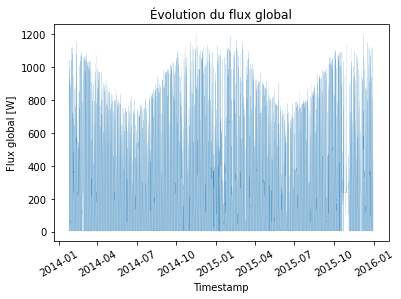

In [121]:
df = pd.read_csv('Moufia_2014_2015/moufia_2014_2015_treated.csv', index_col='Timestamp')
df.index = df.index.astype('datetime64[ns]')

plt.plot(df.index, df.FG_Avg, linewidth=0.1)
plt.xticks(rotation=30)
plt.ylabel('Flux global [W]')
plt.xlabel('Timestamp')
plt.title('Évolution du flux global')
plt.show()

In [122]:
def get_Y(df, lag, h):
    dfY = pd.DataFrame()
    dfY['FG_Avg'] = df['FG_Avg'].shift(-h)
    dfY.drop(dfY.index[:lag], inplace=True)
    dfY.drop(dfY.index[-h-1:], inplace=True)
    dfY.fillna(dfY.mean(), inplace=True)
    return dfY.values

def get_X(df, lag, h):
    dfX = df.drop(['FG_Avg'], axis=1)
    for l in range(1, lag+1):
        for col in ['FD_Avg', 'FG_Avg', 'RH_Avg', 'Text_Avg', 'WD_MeanUnitVector', 'WS_Mean']:
            dfX[col+'_'+str(l)] = df[col].shift(l)
    dfX.drop(dfX.index[:lag], inplace=True)
    dfX.drop(dfX.index[-h-1:], inplace=True)
    dfX.fillna(dfX.mean(), inplace=True)
    return dfX.values

def get_split_train_test(Xs, Ys, horizon, split):
    Xs_train = [Xs[h][:split] for h in range(horizon)]
    Ys_train = [Ys[h][:split] for h in range(horizon)]
    Xs_test = [Xs[h][split:] for h in range(horizon)]
    Ys_test = [Ys[h][split:] for h in range(horizon)]
    return Xs_train, Ys_train, Xs_test, Ys_test

horizon = 4 # 7
lag = 20 # 10
cols = ['FD_Avg','RH_Avg', 'Text_Avg', 'WD_MeanUnitVector', 'WS_Mean']

from sklearn.preprocessing import MinMaxScaler
df[cols] = MinMaxScaler().fit_transform(df[cols].values)
Xs = [get_X(df, lag, h) for h in range(horizon)]
Ys = [get_Y(df, lag, h) for h in range(horizon)]

split = int(0.7*(len(df)))
Xs_train, Ys_train, Xs_test, Ys_test = get_split_train_test(Xs, Ys, horizon, split)

# Grid Search Cross Validation

In [110]:
n_jobs = -1
cv = 10

def print_metric(name, score, std=0):
    print(name, ' : ' + format(score, '.3f'), '' if std==0 else ' (+/-) ' + format(std, '.3f'))

from sklearn.model_selection import GridSearchCV
def get_param_best(Reg, X_train, y_train, param_grid, param_default):
    grid = GridSearchCV(Reg(**param_default), param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=1, scoring='neg_root_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    print('Best : ', grid_result.best_score_, ' using ', grid_result.best_params_)
    return grid_result.best_params_

from sklearn.model_selection import cross_val_score
def print_metrics_cv(Reg, X_train, y_train, param_default):
    reg = Reg(**param_default)
    score = cross_val_score(reg, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring='neg_root_mean_squared_error')
    print_metric('CV RMSE ', score.mean(), 1.96*score.std()/np.sqrt(cv))
    score = cross_val_score(reg, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring='neg_mean_absolute_error')
    print_metric('CV MAE  ', score.mean(), 1.96*score.std()/np.sqrt(cv))
    score = cross_val_score(reg, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring='r2')
    print_metric('CV R2   ', score.mean(), 1.96*score.std()/np.sqrt(cv))

# REGRESSION LINERAIRE

In [107]:
from sklearn.linear_model import LinearRegression

for h in range(horizon):
    param_default = dict(n_jobs=n_jobs)
    print_metrics_cv(LinearRegression, Xs_train[h], Ys_train[h], param_default)

CV RMSE   : -76.964  (+/-) 6.419
CV MAE    : -51.953  (+/-) 4.044
CV R2     : 0.930  (+/-) 0.007
CV RMSE   : -109.416  (+/-) 9.044
CV MAE    : -76.118  (+/-) 5.983
CV R2     : 0.858  (+/-) 0.014
CV RMSE   : -126.010  (+/-) 10.673
CV MAE    : -87.485  (+/-) 6.885
CV R2     : 0.812  (+/-) 0.018
CV RMSE   : -133.344  (+/-) 12.739
CV MAE    : -88.908  (+/-) 7.695
CV R2     : 0.790  (+/-) 0.024


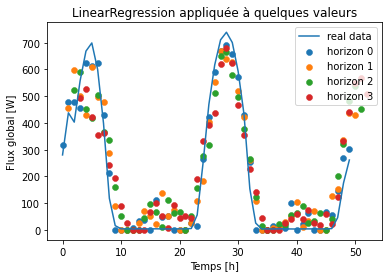

In [124]:
for h in range(horizon):
    reg = LinearRegression()
    reg.fit(Xs_train[h], Ys_train[h])
    plt.scatter(range(h, 50+h), reg.predict(Xs_test[h][:50]).clip(min=0), label=f'horizon {h}', linewidths=0.5)
plt.plot(range(50), Ys_test[0][:50], label='real data')
plt.title('LinearRegression appliquée à quelques valeurs')
plt.ylabel('Flux global [W]')
plt.xlabel('Temps [h]')
plt.legend()

# RESEAU DE NEURONES

In [117]:
from sklearn.neural_network import MLPRegressor

for h in range(horizon):
    param_default = dict(random_state=1)
    param_grid = dict(hidden_layer_sizes=[(30,),(30,30)], max_iter=[500], solver=['lbfgs', 'adam'],
                      activation=['relu'], learning_rate=['adaptive'])
    param_best = get_param_best(MLPRegressor, Xs_train[h], np.ravel(Ys_train[h]), param_grid, param_default)
    print_metrics_cv(MLPRegressor, Xs_train[h], np.ravel(Ys_train[h]), param_best)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished


Best :  -84.07701568487657  using  {'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}
CV RMSE   : -84.813  (+/-) 8.630
CV MAE    : -46.953  (+/-) 4.236
CV R2     : 0.917  (+/-) 0.011
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished


Best :  -108.93720672082438  using  {'activation': 'relu', 'hidden_layer_sizes': (30, 30), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}
CV RMSE   : -109.985  (+/-) 10.676
CV MAE    : -60.984  (+/-) 6.107
CV R2     : 0.858  (+/-) 0.018
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished


Best :  -121.77494433174846  using  {'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}
CV RMSE   : -121.064  (+/-) 11.237
CV MAE    : -72.887  (+/-) 7.099
CV R2     : 0.822  (+/-) 0.018
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.0min finished


Best :  -128.13826455713019  using  {'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}
CV RMSE   : -129.849  (+/-) 12.865
CV MAE    : -74.668  (+/-) 7.914
CV R2     : 0.808  (+/-) 0.023


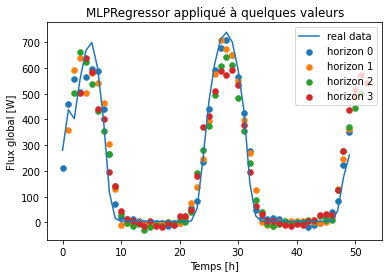

In [119]:
param_bests = [{'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}]*horizon

for h in range(horizon):
    param_best = param_bests[h]
    reg = MLPRegressor(**param_best)
    reg.fit(Xs_train[h], np.ravel(Ys_train[h]))
    plt.scatter(range(h, 50+h), reg.predict(Xs_test[h][:50]), label=f'horizon {h}', linewidths=0.5)
plt.plot(range(50), Ys_test[0][:50], label='real data')
plt.title('MLPRegressor appliqué à quelques valeurs')
plt.ylabel('Flux global [W]')
plt.xlabel('Temps [h]')
plt.legend()